# M5 Sky Area Optical Elements

The M5 metric is designed to verify the fraction of the survey area to receive observations in the different filters requested by different science cases. This notebook is designed to explore the results of this metric calculated for the RGPS survey design.

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
import healpy as hp
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [4]:
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

## M5 Sky Area Optical Element

This metric evaluates the total area of sky to receive observations in each optical element, and combinations of the filters, as a proxy for color measurements.  

This metric calculates two separate values.  The first metric (M5_%sky_area_single_filter) simply calculates the total sky area of the survey foorprint to receive coverage in a given single filter.  

The second metric, M5_sky_area_filter_combo, calculates the sky area to receive observations in multiple filters.  The set of combinations of filters to consider are drawn from both the science cases proposed in each category, and the survey design. 

Note that both of these metrics return values in sky area in square degrees, not percentages. 

In [6]:
# Load the M6 metric results for the wide area science category as an example
m5_results_file = path.join(getcwd(), '..', 'metric_results', 'M5_sky_area_optical_elements_combined_results.txt')

m5_results = Table.read(m5_results_file, format='ascii')
m5_results.pprint_all()

Survey_strategy                  Optic                  M5_sky_area_single_filter M5_sky_area_filter_combo
--------------- --------------------------------------- ------------------------- ------------------------
      wide_area                                    F062                       0.0                      nan
      wide_area                                    F087                       0.0                      nan
      wide_area                                    F106                      8.75                      nan
      wide_area                                    F129                    715.85                      nan
      wide_area                                    F158                    715.85                      nan
      wide_area                                    F184                    555.85                      nan
      wide_area                                    F213                    715.85                      nan
      wide_area                      

The simplest form of this metric is to calculate the total sky area covered in each filter, summing over all regions within each survey element.  

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_19352/1826892332.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right')


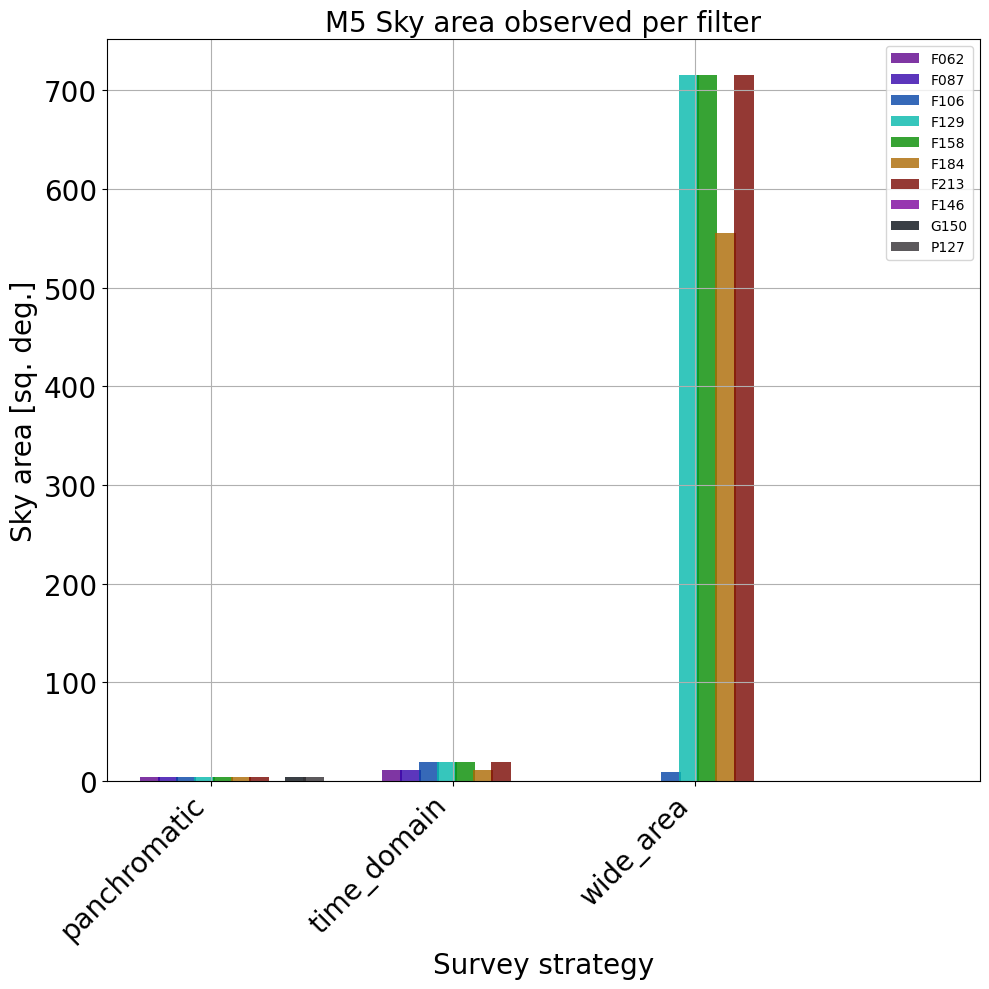

In [9]:
# Plot the sky area covered in different single filters for each survey strategy

# Make a list of the survey strategies included 
surveys = list(set(m5_results['Survey_strategy'].data))
surveys.sort()

bar_width = 1.0 / (len(sim_config['OPTICAL_COMPONENTS'])+2)

# Plot the metric results 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

for k, optic in enumerate(sim_config['OPTICAL_COMPONENTS']):
    bar_offset = bar_width * (k - k/len(sim_config['OPTICAL_COMPONENTS']))
    
    fdx = m5_results['Optic'] == optic
    metric_filter = m5_results[fdx]
    
    data = []
    for i,survey_name in enumerate(surveys):
        jdx = np.where(metric_filter['Survey_strategy'] == survey_name)[0]
        data.append([i+bar_offset, metric_filter[jdx]['M5_sky_area_single_filter'][0]])
    data = np.array(data)

    ax.bar(data[:,0], data[:,1], bar_width,
            color=sim_config['PLOT_COLORS'][optic], alpha=0.8,
           label=optic)
    #ax.plot(range(0,len(surveys),1), data, color=sim_config['PLOT_COLORS'][optic], linestyle='-')

ax.set_xlabel('Survey strategy', fontsize=20)
ax.set_ylabel('Sky area [sq. deg.]', fontsize=20)
ax.set_title('M5 Sky area observed per filter', fontsize=20)
ax.set_xticks(np.arange(0,len(surveys),1) + 0.25)
ax.set_xticklabels(surveys, rotation=45.0, horizontalalignment='right', fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right')
[xmin,xmax] = ax.get_xlim()
ax.set_xlim([xmin, xmax*1.2])
ax.legend()
ax.grid()
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm5_results_sky_area_single_filter.png'))
#plt.close()

Several different science cases require observations of the same region in different combinations of filter, so the second aspect to this metric is to calcuate the sky area covered with the different filter combinations requested by the community. 

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_19352/1526603452.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, horizontalalignment='right', fontsize=25)


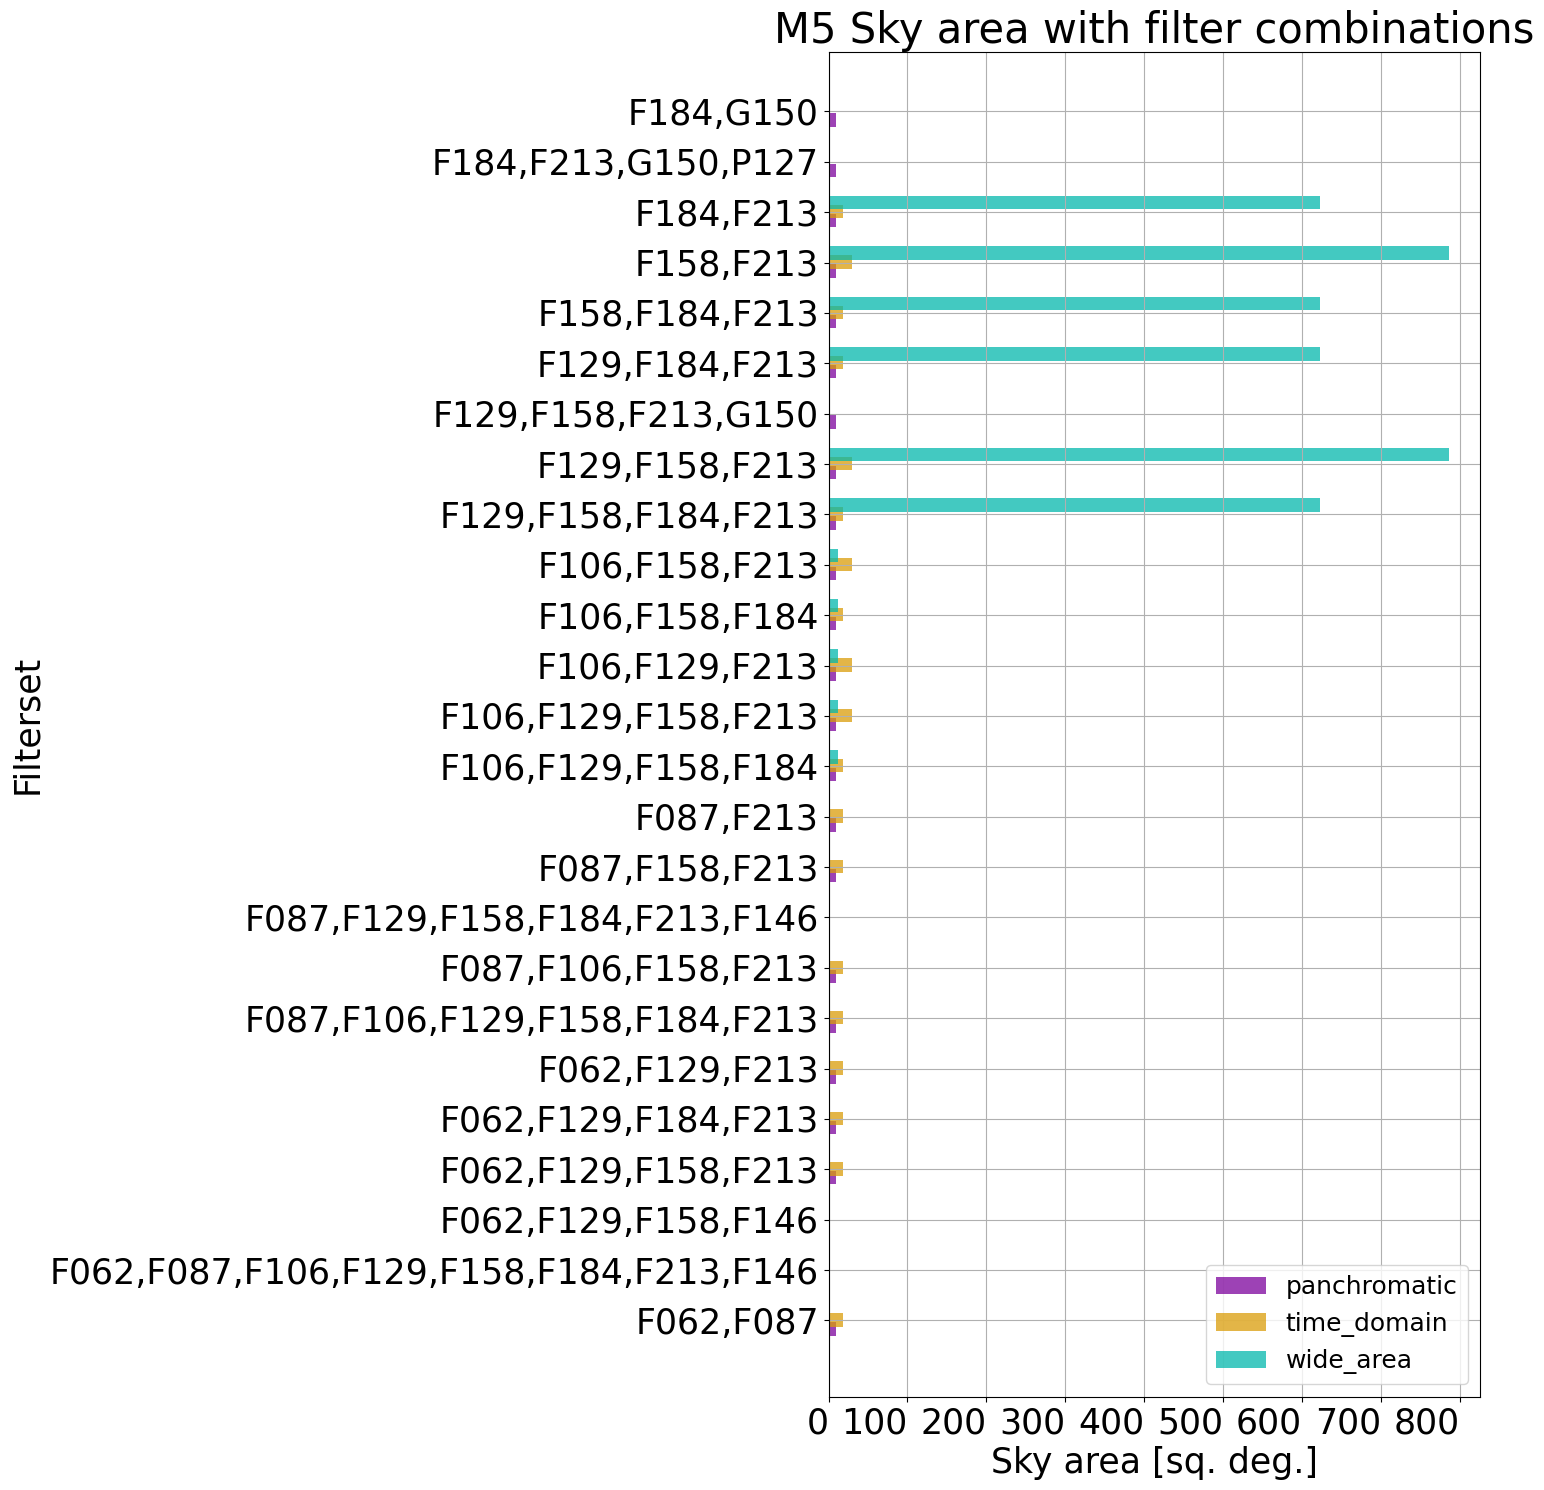

In [10]:
# Extract from the metric results entries referring to combinations of multiple filters and make a list of the combinations included.
flist = []
for f in m5_results['Optic']: 
    if ',' in f:
        flist.append(f)
filter_sets = list(set(flist)) 
filter_sets.sort()

#cmap = mpl.colormaps['viridis']
#plot_colors = cmap(np.linspace(0, 1, len(filter_sets)))

#plot_colors = ["#3303ab", "#0344a6", "#04b8ac", "#058c01", "#ab6902", "#7a0701", "#7d039c", "#080f17", "#333033"]
plot_colors = ["#7d039c", "#da9d09", "#04b8ac"]
plot_symbols = ["o", "v", "s", "p", "d", "P", "*", "<", ">"]
plot_lines = ['-.', '--', '-']
bar_width = 0.8 / len(surveys)

# Select the survey strategy to plot
surveys = list(set(m5_results['Survey_strategy'].data))
surveys.sort()

# Plot the metric results 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

for i,survey_name in enumerate(surveys):
    bar_offset = bar_width * (i - i/len(surveys)) - (1.0/len(surveys)/2.0)
    
    fdx = m5_results['Survey_strategy'] == survey_name
    metric_filter = m5_results[fdx]

    data = []
    for j,f in enumerate(filter_sets):
        jdx = np.where(metric_filter['Optic'] == f)[0]
        if metric_filter[jdx]['M5_sky_area_filter_combo'][0] > 0.0:
            data.append([j+bar_offset, metric_filter[jdx]['M5_sky_area_filter_combo'][0]])
    data = np.array(data)
    
    ax.barh(data[:,0], data[:,1], bar_width,
            color=plot_colors[i], alpha=0.75,
           label=survey_name)

ax.set_ylabel('Filterset', fontsize=25)
ax.set_xlabel('Sky area [sq. deg.]', fontsize=25)
ax.set_title('M5 Sky area with filter combinations', fontsize=30)

ax.set_yticks(range(0,len(filter_sets),1))
ax.set_yticklabels(filter_sets, horizontalalignment='right', fontsize=25)

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, horizontalalignment='right', fontsize=25)
[xmin,xmax] = ax.get_xlim()
ax.set_xlim([xmin, xmax])

ax.legend(loc='lower right', fontsize=18)
ax.grid()
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm5_results_sky_area_filter_combo.png'))
#plt.close()

Bearing in mind that this is the plot for community proposals for wide-area surveys, it is instructive to compare it with the filter sets requested for the different science categories. 

In [11]:
# Plot the metric results for each category except wide-area, which has already been plotted
plot_categories = {}
for category in science_categories:
    if category != 'wide_area': 
        # Load the metric data for this category
        m5_results_file = path.join(getcwd(), '..', 'metric_results', 'M5_sky_area_optical_elements_' + category + '_results.txt')
        m5_results = Table.read(m5_results_file, format='ascii')

        # Collect the set of filter combinations requested by this science category 
        # Not all of them do, so we may skip some here
        flist = []
        for f in m5_results['Optic']: 
            if ',' in f:
                flist.append(f)
        filter_sets = list(set(flist)) 
        filter_sets.sort()

        if len(filter_sets) > 0: 
            plot_categories[category] = {
                'm5_results': m5_results,
                'filter_sets': filter_sets
            }
            
        else:
            print('Skipping ' + category + ' which did not request any combinations of filters')
            
ncols = 2
nrows = int(np.ceil(float(len(plot_categories))/float(ncols)))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,25))
fig.subplots_adjust(hspace=0.1, wspace=0.3)

irow = 0
icol = 0
iplot = -1
for category, params in plot_categories.items():
    iplot += 1
    
    # Load the metric data for this category
    m5_results = params['m5_results']
    filter_sets = params['filter_sets']
    
    for k,survey_name in enumerate(surveys):
        bar_offset = bar_width * (k - k/len(surveys)) - (1.0/len(surveys)/2.0)
        
        fdx = m5_results['Survey_strategy'] == survey_name
        metric_filter = m5_results[fdx]
        
        data = []
        for j,f in enumerate(filter_sets):
            jdx = np.where(metric_filter['Optic'] == f)[0]
            if len(jdx) > 0 and metric_filter[jdx]['M5_sky_area_filter_combo'][0] > 0.0:
                data.append([j+bar_offset, metric_filter[jdx]['M5_sky_area_filter_combo'][0]])
            else:
                data.append([j+bar_offset, 0.0])
        data = np.array(data)
        
        axs[irow,icol].barh(data[:,0], data[:,1], bar_width,
            color=plot_colors[k], alpha=0.75,
           label=survey_name)

    axs[irow,icol].set_ylabel('Filterset', fontsize=16)
    axs[irow,icol].set_xlabel('Sky area [sq. deg.]', fontsize=16)
    (xmin, xmax) = axs[irow, icol].get_xlim()
    (ymin, ymax) = axs[irow, icol].get_ylim()
    if (data[:,1] == 0.0).all():
        xmin = 0.0
        xmax = 120.0
        axs[irow, icol].set_xlim([xmin,xmax])
    axs[irow, icol].annotate(category, ((xmin+0.1), ymax), fontsize=18)

    axs[irow,icol].set_yticks(range(0,len(filter_sets),1))
    yticklabels = []
    for ylab in filter_sets:
        if len(ylab.split(',')) > 6: 
            entries = ylab.split(',')
            yticklabels.append(','.join(entries[0:5]) + ',\n' + ','.join(entries[6:]))
        else:
            yticklabels.append(ylab)
    axs[irow,icol].set_yticklabels(yticklabels, horizontalalignment='right', fontsize=16)
    
    xticklabels = axs[irow,icol].get_xticklabels()
    axs[irow,icol].set_xticklabels(xticklabels, horizontalalignment='right', fontsize=16)
    [xmin,xmax] = axs[irow,icol].get_xlim()
    axs[irow,icol].set_xlim([xmin, xmax])
    
    #axs[irow,icol].legend(loc='lower right', fontsize=16)
    axs[irow,icol].grid()
        
    icol += 1
    if icol == ncols:
        icol = 0
        irow +=1

# We have an odd number of plots so switch off the empty plot
axs[6, 1].set_axis_off()

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm5_results_sky_area_filter_combo_categories.png'))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rstreet/software/rgps/notebooks/../metric_results/M5_sky_area_optical_elements_time_domain_results.txt'